# Train a Random Forest

First, the necessary set-up.

In [1]:
# To be able to edit modules while running this
%load_ext autoreload
%autoreload 2
# Display plots inline
%matplotlib notebook
import numpy as np

## Import Data

Import database data

In [2]:
print "Loading segments, features, matches"
from load_segments import load_segments
from load_segments import load_features
from load_segments import load_matches
segments, sids = load_segments()
features, fnames, fids = load_features()
matches = load_matches() 

## The loaded ids should match.
non_matching_ids = np.where( np.array(sids) != np.array(fids) )[0]
assert non_matching_ids.shape[0] == 0
ids = sids
assert len(ids) == len(segments)

print "  Found " + str(len(ids)) + " segment ids"

Loading segments, features, matches
  Found 922 segments
  Found features for 922 segments (incl. autoencoder features)  
  Found 213 groups of matches
  Found 922 segment ids


Otherwise, import run data

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./database') if isfile(join('./database', f))]
# Dates
run_dates = list(set([filename[4:23] for filename in onlyfiles if filename[0:4] == 'run_' ]))
run_dates.sort()
# Sort filenames into runs
runs = [sorted([filename for filename in onlyfiles if date in filename]) for date in run_dates]
# Ensure that each run has 3 files
for run_filenames in runs:
    assert len(run_filenames) == 3

for i, filename in enumerate(runs[0]):
  if 'features' in filename: features_file_index = i
  if 'matches' in filename: matches_file_index = i
  if 'segments' in filename: segments_file_index = i

In [4]:
from ipywidgets import widgets
run_dropdown = widgets.Dropdown(description="Run to import : ", options=run_dates)
button = widgets.Button(description="import")

# Interaction functions
from load_segments import load_segments
from load_segments import load_features
from load_segments import load_matches
def import_run_data(btn):
  display.clear_output()
  global run_index
  run_index = run_dates.index(run_dropdown.value)
  print "Loading segments, features, matches for run"
  global segments, sids, features, fnames, fids, matches, ids
  segments, sids = load_segments(filename=runs[run_index][segments_file_index])
  features, fnames, fids = load_features(filename=runs[run_index][features_file_index])
  matches = load_matches(filename=runs[run_index][matches_file_index])
  ## The loaded ids should match.
  non_matching_ids = np.where( np.array(sids) != np.array(fids) )[0]
  assert non_matching_ids.shape[0] == 0
  ids = sids
  assert len(ids) == len(segments)
  print "  Found " + str(len(ids)) + " segment ids"

button.on_click(import_run_data)
# Display widgets
from IPython import display
display.display(run_dropdown)
display.display(button)

Loading segments, features, matches for run
  Found 2134 segments
  Found features for 2134 segments (incl. autoencoder features)  
  Found 338 groups of matches
  Found 2134 segment ids


In [5]:
fnames

['linearity',
 'planarity',
 'scattering',
 'omnivariance',
 'anisotropy',
 'eigen_entropy',
 'sum_of_eigenvalues',
 'change_of_curvature',
 'autoencoder_feature1',
 'autoencoder_feature2',
 'autoencoder_feature3',
 'autoencoder_feature4',
 'autoencoder_feature5',
 'x_scale',
 'y_scale',
 'z_scale']

Resulting features

In [6]:
#split_at = int(0.9 * len(ids))
#features_a = features[:split_at]
#features_b = features[split_at:]
#
#import compute_features
#compute_features.compare_features(features_a, features_b, fnames,
#    title=" in Matched Segments from Two Clouds - Eigenvalue Approach")

## Random Forest Matcher

Create the random forest. Run this again if you want to reset the RF.

In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=2)

Fit the random forest.

In [11]:
print "Generating samples"
import match_segments
# training samples
train, target = match_segments.generate_samples(ids, features, matches,
        n_samples=10000, ratio_of_matches_to_non_matches=0.8)
# sample weights
sample_weights = np.ones(len(target))
sample_weights[np.where(np.array(target) == 0)] = 0.01 # Boost importance of negatives
sample_weights[np.where(np.array(target) == 1)] = 1. # Reduce importance of positives
print "Training matcher"
rf.fit(train, target, sample_weights)
print "  Done."

Generating samples
Training matcher
  Done.


Test the random forest iteratively.

In [12]:
test_iterations = 10
samples_per_iteration = 10

import match_segments
# test samples
wrong_predictions = 0
total_predictions = 0
for i in range(test_iterations):
  test, test_target = match_segments.generate_samples(ids, features, matches,
    n_samples=samples_per_iteration, 
    ratio_of_matches_to_non_matches=0.5)
  prediction = rf.predict(test)
  wrong_predictions += int(np.sum(np.abs(np.array(test_target)-prediction)))
  total_predictions += samples_per_iteration

print "  Accuracy:",
print total_predictions - wrong_predictions ,
print "/",
print total_predictions

  Accuracy: 91 / 100


Alternatively, you can test the random forest only once.

In [13]:
import match_segments
# test samples
print "Generating test samples"
test, test_target = match_segments.generate_samples(ids, features, matches,
    n_samples=10, 
    ratio_of_matches_to_non_matches=0.5)
print "Testing matcher"
prediction = rf.predict(test)
print "  Target:    ",
print np.array(test_target)
print "  Prediction:",
print prediction
print "  Error:",
print np.sum(np.abs(np.array(test_target)-prediction))
print "  -----"
print "  Proba:",
print rf.predict_proba(test)[:,1]

Generating test samples
Testing matcher
  Target:     [ 1.  1.  0.  1.  0.  0.  1.  0.  0.  1.]
  Prediction: [ 1.  1.  0.  1.  0.  0.  1.  0.  0.  1.]
  Error: 0.0
  -----
  Proba: [ 0.9   0.92  0.44  0.99  0.39  0.07  0.91  0.47  0.38  0.98]


In [14]:
samples = 1000

import match_segments
# test samples
test, test_target = match_segments.generate_samples(ids, features, matches,
  n_samples=samples, 
  ratio_of_matches_to_non_matches=0.5)
prediction = rf.predict(test)
true_positives  = np.sum(((np.logical_and(prediction==1.0, np.array(test_target)==1.0))).astype(int))
true_negatives  = np.sum(((np.logical_and(prediction==0.0, np.array(test_target)==0.0))).astype(int))
false_positives = np.sum(((np.logical_and(prediction==1.0, np.array(test_target)==0.0))).astype(int))
false_negatives = np.sum(((np.logical_and(prediction==0.0, np.array(test_target)==1.0))).astype(int))

print "  True Positives:",
print true_positives
print "  True Negatives:",
print true_negatives
print "  False Positives:",
print false_positives
print "  False Negatives:",
print false_negatives
print " Total:",
print samples

  True Positives: 495
  True Negatives: 412
  False Positives: 88
  False Negatives: 5
 Total: 1000


Feature importances

<IPython.core.display.Javascript object>


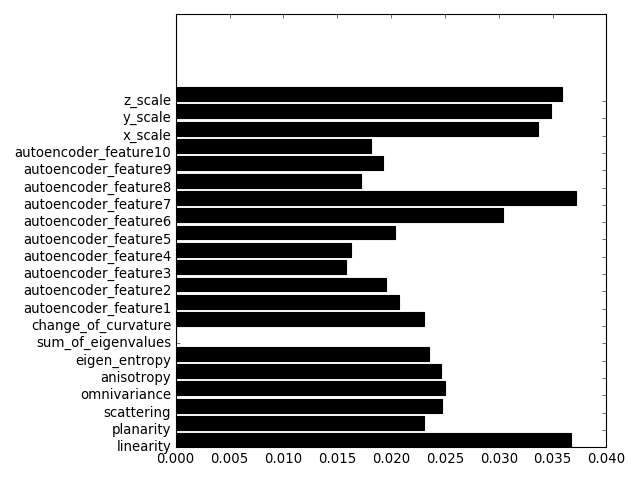

In [30]:
probabilities_of_being_a_match = rf.predict_proba(test)[:,1]
n = len(rf.feature_importances_)/2
zip(fnames, rf.feature_importances_[:n], rf.feature_importances_[n:])
average_importances = (rf.feature_importances_[:n] + rf.feature_importances_[n:]) / 2
sorted_indices = np.argsort(average_importances)
#zip(np.array(fnames)[sorted_indices], average_importances[sorted_indices])[::-1]
import matplotlib.pyplot as plt
plt.barh(np.arange(len(fnames)), average_importances, color='k', tick_label=fnames)
plt.tight_layout()

## Visualisation

<IPython.core.display.Javascript object>


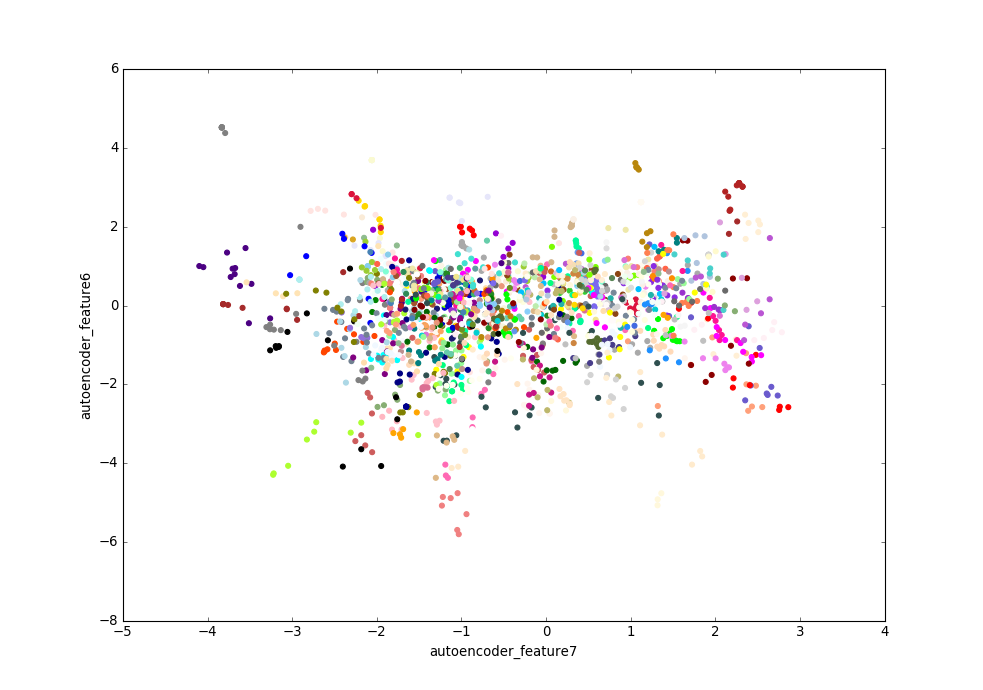

In [11]:
from ipywidgets import widgets
x_feature_dropdown = widgets.Dropdown(description="x-axis Feature: ", options=fnames)
y_feature_dropdown = widgets.Dropdown(description="y-axis Feature: ", options=fnames)
button = widgets.Button(description="clear")
button2 = widgets.Button(description="force rescale")

# Interaction functions
import matplotlib.pyplot as plt
from compute_features import visualize_matches_for_two_features
def plot_features(btn):
  x_index = fnames.index(x_feature_dropdown.value)
  y_index = fnames.index(y_feature_dropdown.value)
  plt.figure(fig.number)
  plt.cla()
  visualize_matches_for_two_features(x_index, y_index,
                                     ids, features, fnames, matches)
x_feature_dropdown.observe(plot_features)
y_feature_dropdown.observe(plot_features)
button2.on_click(plot_features)
def clear_display(btn):
  display.clear_output()
button.on_click(clear_display)
# Display widgets
from IPython import display
display.display(x_feature_dropdown)
display.display(y_feature_dropdown)
display.display(widgets.HBox((button2, button)))

import matplotlib.pyplot as plt
fig = plt.figure()
plot_features(0)

In [14]:
max([len(group) for group in matches])

12

# Match Segments Between Two Runs

Enumerate available runs

In [15]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('./database') if isfile(join('./database', f))]
# Dates
run_dates = list(set([filename[4:23] for filename in onlyfiles if filename[0:4] == 'run_' ]))
run_dates.sort()
# Sort filenames into runs
runs = [sorted([filename for filename in onlyfiles if date in filename]) for date in run_dates]
# Ensure that each run has 3 files
for run_filenames in runs:
    assert len(run_filenames) == 3

for i, filename in enumerate(runs[0]):
  if 'features' in filename: features_file_index = i
  if 'matches' in filename: matches_file_index = i
  if 'segments' in filename: segments_file_index = i

Select runs to load

In [16]:
from ipywidgets import widgets
run_a_dropdown = widgets.Dropdown(description="Run A : ", options=run_dates)
run_b_dropdown = widgets.Dropdown(description="Run B : ", options=run_dates)
button = widgets.Button(description="import")

# Interaction functions
from load_segments import load_segments
from load_segments import load_features
from load_segments import load_matches
def import_runs_data(btn):
  display.clear_output()
  run_a_index = run_dates.index(run_a_dropdown.value)
  run_b_index = run_dates.index(run_b_dropdown.value)
  if run_a_index == run_b_index:
        print "Warning: selected identical runs."
  print "Loading segments, features, matches for run A"
  global a_segments, a_sids, a_features, a_fnames, a_fids, a_matches, a_ids
  a_segments, a_sids = load_segments(filename=runs[run_a_index][2])
  a_features, a_fnames, a_fids = load_features(filename=runs[run_a_index][0])
  a_matches = load_matches(filename=runs[run_a_index][1])
  ## The loaded ids should match.
  non_matching_ids = np.where( np.array(a_sids) != np.array(a_fids) )[0]
  assert non_matching_ids.shape[0] == 0
  a_ids = a_sids
  assert len(a_ids) == len(a_segments)
  print "  Found " + str(len(ids)) + " segment ids"
  print "Loading segments, features, matches for run B"
  global b_segments, b_sids, b_features, b_fnames, b_fids, b_matches, b_ids
  b_segments, b_sids = load_segments(filename=runs[run_b_index][2])
  b_features, b_fnames, b_fids = load_features(filename=runs[run_b_index][0])
  b_matches = load_matches(filename=runs[run_b_index][1]) 
  ## The loaded ids should match.
  non_matching_ids = np.where( np.array(b_sids) != np.array(b_fids) )[0]
  assert non_matching_ids.shape[0] == 0
  b_ids = b_sids
  assert len(b_ids) == len(b_segments)
  print "  Found " + str(len(ids)) + " segment ids"

button.on_click(import_runs_data)
# Display widgets
from IPython import display
display.display(run_a_dropdown)
display.display(run_b_dropdown)
display.display(button)

Loading segments, features, matches for run A
  Found 2134 segments
  Found features for 2134 segments (incl. autoencoder features)  
  Found 338 groups of matches
  Found 2134 segment ids
Loading segments, features, matches for run B
  Found 2095 segments
  Found features for 2095 segments (incl. autoencoder features)  
  Found 319 groups of matches
  Found 2134 segment ids


In [17]:
try:
    a_ids
except:
    import sys
    print >> sys.stderr, "Runs have not been imported yet. Please import them in the previous node."

from ipywidgets import widgets
text = widgets.Text(description="Progress :")
text2 = widgets.Text(description="Predicted Matches :")
from IPython import display
display.display(widgets.HBox((text, text2)))

import itertools
all_possible_pairs = list(itertools.product(a_ids, b_ids))
n_pairs = len(all_possible_pairs)

# Enumerator for splitting list
def fragments(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]
        
predicted_matches = []
predicted_matches_count = 0
progress = 0
fragment_size = 100000
for pairs_batch in fragments(all_possible_pairs, fragment_size):
    x = [list(a_features[a_ids.index(pair[0])]) + list(b_features[b_ids.index(pair[1])]) for pair in pairs_batch]
    predictions = rf.predict_proba(x)[:,1]
    predicted_matches += list(np.array(pairs_batch)[predictions >= 0.99,:])
    text2.value = str(len(predicted_matches))
    # Display progress
    progress += 100.0*float(fragment_size)/n_pairs
    text.value = str(progress) + "%"

text.value = "100%"

predicted_matches = [list(match) for match in predicted_matches]

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [18]:
##DEBUG
predicted_matches[0]

[56, 187]

In [19]:
from load_segments import write_matches
write_matches(predicted_matches)


  371 matches written  to ./database/predicted_matches.csv


### (Alternative) Multicore Version

In [34]:
from ipywidgets import widgets
text = widgets.Text(description="Progress :")
text2 = widgets.Text(description="Predicted Matches :")
from IPython import display
display.display(widgets.HBox((text, text2)))

n_pairs = len(a_ids)*len(b_ids)

# Enumerator for splitting list
def fragments(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

def doWork(i):
    global n_processes, text, text2
    import itertools
    frag_size = len(a_ids)/n_processes
    possible_pairs = list(itertools.product(a_ids[i*frag_size:i+1*frag_size], b_ids))
    
    predicted_matches = []
    predicted_matches_count = 0
    progress = 0
    fragment_size = 100000
    for pairs_batch in fragments(possible_pairs, fragment_size):
        x = [list(a_features[a_ids.index(pair[0])]) + list(b_features[b_ids.index(pair[1])]) for pair in pairs_batch]
        predictions = rf.predict(x)
        predicted_matches += list(np.array(pairs_batch)[predictions >= 0.8,:])
        text2.value = str(len(predicted_matches))
        # Display progress
        progress += 100.0*float(fragment_size)/n_pairs
        text.value = str(progress) + "%"

    predicted_matches = [list(match) for match in predicted_matches]
    return predicted_matches

#create a process Pool with 4 processes
n_processes = 4
from multiprocessing import Pool
pool = Pool(processes=n_processes)
results = pool.map(doWork, (0,1,2,3))

predicted_matches = [item for sublist in results for item in sublist]

0